In [1]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

2025-11-22 14:55:29.674891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-22 14:55:49.524569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-22 14:55:57.909025: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


key question:
- time series and other features? 

In [2]:
# derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
# data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [3]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [4]:
df_series_all.head(10)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_03,Bachtel-Forest,Fagus sylvatica,1,0.593406,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.036220,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_03,Bachtel-Forest,Fagus sylvatica,1,0.360955,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_03,Bachtel-Forest,Fagus sylvatica,1,0.351367,2020,1,2020-01


start from simple model 
- understand the covariance, mean a little better
- gaussian process
- autoregressive model 

1. autoregressive


it seems the lag can be 13... 
- use 13 previous twd observations to build autoregressive model?
- use exogenous variables? 


## data preparation

take median value of same site, same species of twd


? what about temperaturre
 (haven't tested if the same..on the same day at the same site)

In [5]:
 df_series_all.head()


,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_03,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_03,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_03,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_03,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


In [ ]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [7]:
# twd_tree_series_sites

In [8]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [9]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [138]:
# create function class

import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple, List, Optional, Union
from dataclasses import dataclass, field
from functools import lru_cache


@dataclass
class FeatureConfig:
    """Configuration for feature columns"""
    time_varying: List[str] = field(
        default_factory=lambda: ['twd', 'pr', 'at', 'ws', 'dp', 'sr', 'lr']
    )
    time_varying_target: List[str] = field(
        default_factory=lambda: ['twd']
    )
    time_varying_no_target: List[str] = field(
        default_factory=lambda: ['pr', 'at', 'ws', 'dp', 'sr', 'lr']
    )
    static: List[str] = field(
        default_factory=lambda: [
            'mch_elevation', 'mch_easting', 'mch_northing',
            'Carpinus betulus', 'Corylus avellana', 'Fagus sylvatica',
            'Picea abies', 'Pinus sylvestris', 'Pseudotsuga menziesii'
        ]
    )
    cols_to_normalize: List[str] = field(
        default_factory=lambda: ['pr', 'at', 'ws', 'dp', 'sr', 'lr', 
            'mch_elevation', 'mch_easting', 'mch_northing']
    )

def create_training_test_set_optimized(
    df: pd.DataFrame,
    train_size: float = 0.7,
    val_size: float = 0.15,
    feature_window_size: Optional[int] = None,
    autoregressive: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Optimized train/val/test split handling groups efficiently
    """
    # Pre-sort data once
    df = df.sort_values(['site_name', 'species', 'ts'])
    
    # Group data efficiently
    grouped = df.groupby(['site_name', 'species'])
    splits = {'train': [], 'val': [], 'test': []}
    
    for _, group_df in grouped:
        group_df = group_df.reset_index(drop = True)
        n = len(group_df)
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        
        # Handle autoregressive window overlap
        val_start = train_end - (feature_window_size if autoregressive else 0)
        
        splits['train'].append(group_df.iloc[:train_end])
        splits['val'].append(group_df.iloc[val_start:val_end])
        splits['test'].append(group_df.iloc[val_end:])


    return tuple(pd.concat(splits[key]) for key in ['train', 'val', 'test'])

# @lru_cache(maxsize=32)
def get_feature_windows(
    df: pd.DataFrame,
    feature_window_size: int,
    label_window_size: int = 1,
    shift: int = 1,
    autoregressive: bool = False,
    config: Optional[FeatureConfig] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creates sliding windows efficiently using vectorized operations
    """
    config = config or FeatureConfig()
    features_ts_cols = config.time_varying
    features_ts_cols_wo_twd = config.time_varying_no_target
    features_static_cols = config.static
    label_input = df['twd']
    if autoregressive:
        feature_input = df
        n_feature = (feature_window_size +1) * len(features_ts_cols) + len(features_static_cols) -1  # +1 because we would like to keep the current selection, -1 to exclude twd that we would like to predict

    else:
        feature_input = df.drop(columns=['twd'])
        features_ts_cols = features_ts_cols_wo_twd
        n_feature = (feature_window_size +1) * len(features_ts_cols) + len(features_static_cols)

    n_sample = feature_input.shape[0]
    
    # Create feature windows using stride tricks
    n_windows = n_sample - 2*feature_window_size - label_window_size - shift + 1

    # we also need to make sure location and other static features are only included for once...

    # Initialize arrays
     
    features = np.zeros((n_windows, n_feature))
    labels = np.zeros((n_windows, label_window_size))
    
    for i in range(n_windows):
        # Feature window
        start_idx = i
        end_idx = i + feature_window_size
        features[i] = np.concatenate([feature_input[features_ts_cols].iloc[start_idx:end_idx, ].to_numpy().reshape(-1), 
                                         feature_input[features_ts_cols_wo_twd+features_static_cols].iloc[end_idx, ].to_numpy().reshape(-1)])
        
        # Label window
        label_start = i + feature_window_size + shift - 1
        label_end = label_start + label_window_size
        labels[i] = label_input[label_start:label_end]

    
            
    return features, labels


def spliting_windows_df(df: pd.DataFrame, 
                                        feature_window_size: int ,
                                        label_window_size: int,
                                        shift = 1,
                                        autoregressive: bool =False,
                                        feature_index = None,
                                        config: Optional[FeatureConfig] = None):
    
    
    config = config or FeatureConfig()
    features_list = []
    labels_list = []
     
    for site in df.site_name.unique():
        df_site = df[df['site_name'] == site]
        species = df_site['species'].unique()
        
        for sp in species:
            df_sp = df_site[df_site['species'] == sp]\
                .sort_values(by='ts', ascending = True)\
                .drop(["species", "site_name", "ts"], axis = 1).reset_index(drop = True)
            features, labels =  get_feature_windows(df_sp,
                                                    feature_window_size,
                                                    label_window_size,
                                                    shift,
                                                    autoregressive,
                                                    config)
             

            features_list.append(features)
            labels_list.append(labels)

    # Concatenate all features and labels
    all_features = np.concatenate(features_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)


    if feature_index is not None:
        all_features = all_features[:, feature_index]                                             
        
    return all_features, all_labels

def create_dataset(
    features: np.ndarray,
    labels: np.ndarray,
    batch_size: Optional[int] = None,
    as_tensor: bool = False
) -> Union[Tuple[np.ndarray, np.ndarray], tf.data.Dataset]:
    """
    Creates final dataset format efficiently
    """
    if as_tensor:
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)
        
        if batch_size:
            return tf.data.Dataset.from_tensor_slices((features, labels))\
                     .batch(batch_size)\
                     .prefetch(tf.data.AUTOTUNE)
    
    return features, labels

def compute_recursive_predictions(
    model,
    df: pd.DataFrame,
    feature_window_size: int,
    label_window_size: int = 1,
    shift: int = 1,
    config: Optional[FeatureConfig] = None
) -> Tuple[List[float], List[float]]:
    """
    Compute recursive predictions on validation/test set by using
    predicted values as inputs for subsequent predictions
    
    Args:
        model: Trained model with predict method
        df: DataFrame with features and target
        feature_window_size: Size of sliding window for features
        label_window_size: Size of prediction window
        shift: Number of steps to shift between windows
        config: Feature configuration
        
    Returns:
        Tuple of predictions and true values
    """
    config = config or FeatureConfig()
    predictions = []
    true_values = []
    
    # Group by site and species
    for site in df.site_name.unique():
        df_site = df.loc[df['site_name'] == site,]
        species = df_site['species'].unique()   
        for sp in species:
            df_group = df_site[df_site['species'] == sp].sort_values(by='ts', ascending = True).reset_index(drop = True)
            
            # Get features and labels
            feature_input = df_group
            label_input = df_group['twd']
            
            n_sample = len(df_group)
            n_windows = n_sample - 2*feature_window_size - label_window_size - shift + 1
            
            for i in range(n_windows):
                # Get window of data
                window_df = feature_input.iloc[i:i+2*feature_window_size+1, ].reset_index(drop=True).copy()
                window_labels = label_input[i:i+2*feature_window_size+1, ].reset_index(drop=True)
                
                # Recursive prediction for each step in window
                for step in range(0, feature_window_size + 1):
                    # Prepare features
                    start_idx = step
                    end_idx = step + feature_window_size
                    
                    time_varying = window_df[config.time_varying].iloc[start_idx:end_idx].values.reshape(-1)
                    static = window_df[config.static].iloc[end_idx].values
                    other_features = window_df[config.time_varying_no_target].iloc[end_idx].values
                    

                    # features= np.concatenate([window_df[config.time_varying].iloc[start_idx:end_idx, ].to_numpy().reshape(-1), 
                    #                         window_df[config.time_varying_no_target +config.static].iloc[end_idx, ].to_numpy().reshape(-1)])
                    features = np.concatenate([time_varying, other_features, static])
                    
                    label_start = step + feature_window_size + shift - 1
                    label_end = label_start + label_window_size
                    label= window_labels[label_start:label_end]

                    # Make prediction
                    pred = model.predict(features.reshape(1, -1))[0]
                    
                    # Store final prediction or update window
                    if step == feature_window_size:
                        predictions.append(pred)
                        true_values.append(label)
                    else:
                        window_df.at[label_start, 'twd'] = pred
    
    return np.array(predictions), np.array(true_values)


def compute_recursive_predictions_fast(
    model,
    df: pd.DataFrame,
    feature_window_size: int,
    label_window_size: int = 1,
    shift: int = 1,
    config: Optional[FeatureConfig] = None,
    batch_size: int = 64,
    tensor = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Vectorized autoregressive recursive predictions.
    - Builds sliding windows per (site, species) once.
    - Predicts in batches: one model.predict call per recursion step across all windows.
    - Updates the target inside the windows with predicted values so subsequent steps use preds.
    Returns (preds, trues) as 1D numpy arrays (matching original function semantics).
    """
    config = config or FeatureConfig()
    preds_all = []
    trues_all = []

    per_row_cols = config.time_varying + config.time_varying_no_target+ config.static
    n_tvt = len(config.time_varying)
    n_other = len(config.time_varying_no_target)
    n_static = len(config.static)

    # index of twd inside the time_varying block
    idx_twd_in_tvt = config.time_varying.index("twd")

    for site in df.site_name.unique():
        df_site = df.loc[df['site_name'] == site, :]
        for sp in df_site['species'].unique():
            df_group = (
                df_site[df_site['species'] == sp]
                .sort_values('ts', ascending=True)
                .reset_index(drop=True)
            )
            n_sample = len(df_group)
            window_len = 2 * feature_window_size + 1 
            n_windows = n_sample - 2*feature_window_size - label_window_size - shift + 1
            if n_windows <= 0:
                continue

            # convert to numpy once
            arr = df_group[per_row_cols].to_numpy(dtype=float)  # shape (n_sample, cols)

            # build sliding windows: shape (n_windows, window_len, cols)
            windows = np.stack([arr[i : i + window_len] for i in range(n_windows)], axis=0)

            # column indices inside per-row block
            idx_tvd = list(range(0, n_tvt))
            idx_other = list(range(n_tvt, n_tvt + n_other))
            idx_static = list(range(n_tvt + n_other, n_tvt + n_other + n_static))

            # recursive steps: predict step-by-step, updating windows with preds
            for step in range(0, feature_window_size + 1):
                start = step
                end = start + feature_window_size  # exclusive end for slicing past lags; current index = end

                # flattened lagged time-varying features for all windows at this step
                tv_block = windows[:, start:end, :][:, :, idx_tvd].reshape(n_windows, -1)

                # current-day non-target and static features (at index 'end')
                other_feats = windows[:, end, :][:, idx_other] if n_other > 0 else np.empty((n_windows, 0))
                static_feats = windows[:, end, :][:, idx_static] if n_static > 0 else np.empty((n_windows, 0))

                X_batch = np.concatenate([tv_block, other_feats, static_feats], axis=1)

                # one predict call for all windows at this step
                if tensor:
                    y_batch = model.predict(X_batch, batch_size=batch_size).reshape(-1)
                else: 
                    y_batch = model.predict(X_batch).reshape(-1)

                # label index inside window to read true or overwrite with prediction
                label_start = step + feature_window_size + shift - 1
                label_end = label_start + label_window_size

                if step == feature_window_size:
                    # final step: collect predictions and true labels
                    true_labels = windows[:, label_start:label_end, idx_twd_in_tvt].reshape(-1)
                    preds_all.append(y_batch.copy())
                    trues_all.append(true_labels.copy())
                else:
                    # update the 'twd' position for all windows with predicted values (autoregressive feed)
                    windows[:, label_start, idx_twd_in_tvt] = y_batch

    if len(preds_all) == 0:
        return np.array([]), np.array([])

    preds = np.concatenate(preds_all, axis=0)
    trues = np.concatenate(trues_all, axis=0)
    return preds, trues


def compute_recursive_predictions_fast_rollout(
    model,
    df: pd.DataFrame,
    feature_window_size: int,
    label_window_size: int = 1,
    shift: int = 1,
    config: Optional[FeatureConfig] = None,
    batch_size: int = 64,
    tensor = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Vectorized autoregressive recursive predictions.
    - Builds sliding windows per (site, species) once.
    - Predicts in batches: one model.predict call per recursion step across all windows.
    - Updates the target inside the windows with predicted values so subsequent steps use preds.
    Returns (preds, trues) as 1D numpy arrays (matching original function semantics).
    """
    config = config or FeatureConfig()
    preds_all = []
    trues_all = []

    preds_rollout_all = []
    trues_rollout_all = []

    per_row_cols = config.time_varying + config.time_varying_no_target+ config.static
    n_tvt = len(config.time_varying)
    n_other = len(config.time_varying_no_target)
    n_static = len(config.static)

    # index of twd inside the time_varying block
    idx_twd_in_tvt = config.time_varying.index("twd")

    for site in df.site_name.unique():
        df_site = df.loc[df['site_name'] == site, :]
        for sp in df_site['species'].unique():
            df_group = (
                df_site[df_site['species'] == sp]
                .sort_values('ts', ascending=True)
                .reset_index(drop=True)
            )
            n_sample = len(df_group)
            window_len = 2 * feature_window_size + 1 
            n_windows = n_sample - 2*feature_window_size - label_window_size - shift + 1
            if n_windows <= 0:
                continue

            # convert to numpy once
            arr = df_group[per_row_cols].to_numpy(dtype=float)  # shape (n_sample, cols)

            # build sliding windows: shape (n_windows, window_len, cols)
            windows = np.stack([arr[i : i + window_len] for i in range(n_windows)], axis=0)

            # column indices inside per-row block
            idx_tvd = list(range(0, n_tvt))
            idx_other = list(range(n_tvt, n_tvt + n_other))
            idx_static = list(range(n_tvt + n_other, n_tvt + n_other + n_static))

            preds_step = []
            trues_step = []
            
            # recursive steps: predict step-by-step, updating windows with preds
            for step in range(0, feature_window_size + 1):
                start = step
                end = start + feature_window_size  # exclusive end for slicing past lags; current index = end

                # flattened lagged time-varying features for all windows at this step
                tv_block = windows[:, start:end, :][:, :, idx_tvd].reshape(n_windows, -1)

                # current-day non-target and static features (at index 'end')
                other_feats = windows[:, end, :][:, idx_other] if n_other > 0 else np.empty((n_windows, 0))
                static_feats = windows[:, end, :][:, idx_static] if n_static > 0 else np.empty((n_windows, 0))

                X_batch = np.concatenate([tv_block, other_feats, static_feats], axis=1)

                # one predict call for all windows at this step
                if tensor:
                    y_batch = model.predict(X_batch, batch_size=batch_size).reshape(-1)
                else: 
                    y_batch = model.predict(X_batch).reshape(-1)
                
                
                # label index inside window to read true or overwrite with prediction
                label_start = step + feature_window_size + shift - 1
                label_end = label_start + label_window_size

                preds_step.append(y_batch.copy())
                true_labels = windows[:, label_start:label_end, idx_twd_in_tvt].reshape(-1)
                trues_step.append(true_labels.copy())
            
                if step == feature_window_size:
                    # final step: collect predictions and true labels
                    true_labels = windows[:, label_start:label_end, idx_twd_in_tvt].reshape(-1)
                    preds_all.append(y_batch.copy())
                    trues_all.append(true_labels.copy())
                else:
                    # update the 'twd' position for all windows with predicted values (autoregressive feed)
                    windows[:, label_start, idx_twd_in_tvt] = y_batch

            preds_rollout_all.append(np.array(preds_step))
            trues_rollout_all.append(np.array(trues_step))

            
    if len(preds_all) == 0:
        return np.array([]), np.array([])

    preds = np.concatenate(preds_all, axis=0)
    trues = np.concatenate(trues_all, axis=0)
    return preds, trues, np.array(preds_rollout_all), np.array(trues_rollout_all)


def standardize_dataset(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, dict]:
    """
    Standardizes specified columns in train, val, and test DataFrames
    using StandardScaler from sklearn.
    
    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        test_df: Test DataFrame
        cols_to_normalize: List of column names to standardize
        
    Returns:
        Tuple of standardized (train_df, val_df, test_df) and scaler parameters
    """
    cols_to_normalize = config.cols_to_normalize
    scaler = StandardScaler()
    
    
    # Fit and transform the training data
    train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])
    
    # Transform validation and test data using the same scaler
    val_df[cols_to_normalize] = scaler.transform(val_df[cols_to_normalize])
    test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])
    
    # Store scaler parameters for later use if needed
    scaler_params = {
        'mean_': scaler.mean_,
        'scale_': scaler.scale_
    }
    
    return train_df, val_df, test_df


def clip_and_inverse_log2_transform(y_pred: np.ndarray) -> np.ndarray:
    """
    Clips negative predictions to zero and applies inverse log2 transformation.
    
    Args:
        y_pred: Array of predicted values in log2 scale 
    
    Returns:
        Array of predictions in original scale with negatives clipped to zero
    """
    return np.clip(np.power(2, y_pred) - 1, a_min=0, a_max=None)

In [ ]:
testa = [np.array([1, 2, 3])]
testa.append(np.array([4, 5, 6]))
np.array(testa)



4

In [73]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
df_series_features_log2['twd'] = np.log2(1 + df_series_features_log2['twd'])

In [74]:
# Configure features
config = FeatureConfig()
lag_n =13

# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features,
    feature_window_size=lag_n,
    autoregressive=True
)


train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at
)

# Create windows
train_X_at, train_y_at = spliting_windows_df(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_at, val_y_at = spliting_windows_df(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

# Create TensorFlow dataset
train_dataset_at = create_dataset(
    train_X_at,
    train_y_at,
    batch_size=64,
    as_tensor=True
)

val_dataset_at = create_dataset(
    val_X_at,
    val_y_at,
    batch_size=64,
    as_tensor=True
)




train_df, val_df, test_df = create_training_test_set_optimized(
    df_series_features, 
    feature_window_size=lag_n,
    autoregressive=False)

train_df, val_df, test_df = standardize_dataset(
    train_df, val_df, test_df
)

# non-autoregressive
train_X, train_y = spliting_windows_df(
    train_df,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=False,
    shift = 1,
    config=config
)

val_X, val_y = spliting_windows_df(
    val_df,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive = False,
    shift = 1,
    config = config)

train_dataset, val_dataset = create_dataset(
    train_X,
    train_y,
    batch_size=64,
    as_tensor=True
), create_dataset(
    val_X,
    val_y,
    batch_size=64,
    as_tensor=True
)


# create datasplit for log2 autoregressive ridge model
train_df_log2_at, val_df_log2_at, test_df_log2_at = create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_log2_at, val_df_log2_at, test_df_log2_at = standardize_dataset(
    train_df_log2_at, val_df_log2_at, test_df_log2_at
) 


train_X_log2_at, train_y_log2_at = spliting_windows_df(
    train_df_log2_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_log2_at, val_y_log2_at = spliting_windows_df(
    val_df_log2_at,
    feature_window_size=lag_n,
    label_window_size = 1,
    autoregressive=True,
    shift = 1,
    config=config
)






## build simple models - baseline
-  linear regression: autoregressive and non-autoregressive

#### non-Autoregressive
feature selected: 
- 25 days of non-static features (excluding twd) + geo location + species

label:
- twd at day 13
- using log2 transformed values to train the model to avoid non-zero values
 

In [13]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import root_mean_squared_error, r2_score

In [70]:
rgr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5]).fit(train_X, np.log2(1+train_y))
rgr.score(train_X, np.log2(1+train_y))

0.3907495094776472

In [95]:
rmse_train = root_mean_squared_error(train_y, clip_and_inverse_log2_transform(rgr.predict(train_X)))
y_pred_val = clip_and_inverse_log2_transform(rgr.predict(val_X))
rmse_val = root_mean_squared_error(val_y,  y_pred_val)
r2 = r2_score(val_y, y_pred_val)

/tmp/ipykernel_6643/1057981882.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range,x_range, 'k--',
/tmp/ipykernel_6643/1057981882.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--',
/tmp/ipykernel_6643/1057981882.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--',


Text(4.58346527777778, 0.5, 'RMSE: 0.552\n R2: 0.499')

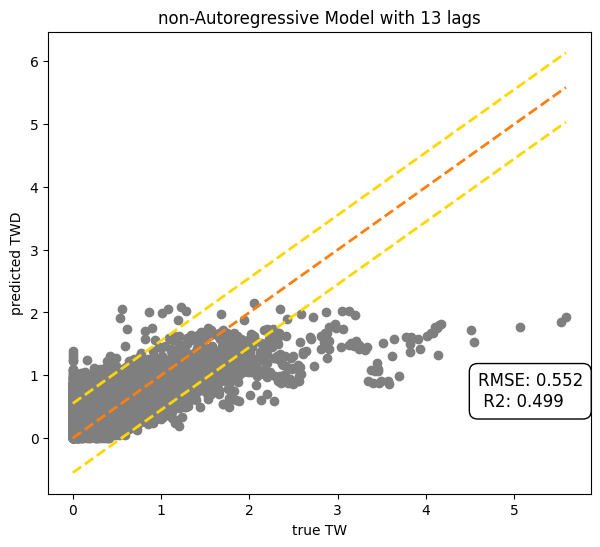

In [78]:
x_scatter = val_y
y_scatter = y_pred_val
rmse_scatter = rmse_val
plt.figure(figsize=(7,6))
plt.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
plt.xlabel("true TW")
plt.ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
plt.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
plt.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
plt.title(f"non-Autoregressive Model with {lag_n} lags")
plt.text(x_scatter.max()-1, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2:.3f}", 
         fontsize=12, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


it looks like it randomly predict value within the range of 0-2

### Autogressive model
feature selected: 
- 24 days of non-static features (including twd) + geo location + species + 25th day of non-static features (excluding twd)

label:
- twd at day 14

In [152]:

rgr_at = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5]).fit(train_X_log2_at, train_y_log2_at)
rgr_at.score(train_X_log2_at, train_y_log2_at)

rmse_train_at = root_mean_squared_error(train_y_log2_at, rgr_at.predict(train_X_log2_at))



fix-horizon prediction, shift 1,3,5? 

autogressive on validation set and test set : forecasting using the value that was predicted 


In [153]:
rgr_at.score(train_X_log2_at, train_y_log2_at)

0.9166260673201401

In [154]:
# compute model performance on validation set using recursive prediction
y_pred_val_at,  val_y_rgr_at = compute_recursive_predictions(rgr_at, val_df_log2_at, feature_window_size=lag_n)
# for the purpose of compare outputs from two function compute_recursive_predictions and compute_recursive_predictions_fast
y_pred_val_at_fast,  val_y_at_fast = compute_recursive_predictions_fast(rgr_at, val_df_log2_at, feature_window_size=lag_n,
                                                              tensor = False)



In [155]:
# compute 1-day ahead prediction performance for comparison
y_pred_1d_val_at_rgr = clip_and_inverse_log2_transform(rgr_at.predict(val_X_log2_at).reshape(-1))
# clip and inverse log2 transform
y_pred_val_at = clip_and_inverse_log2_transform(y_pred_val_at)
y_pred_val_at_fast = clip_and_inverse_log2_transform(y_pred_val_at_fast)


r2_rgr_at_1day = r2_score(np.power(2, val_y_rgr_at)-1, y_pred_1d_val_at_rgr)

r2_rgr_at_fast = r2_score(np.power(2, val_y_at_fast)-1, y_pred_val_at_fast)
rmse_rgr_at_fast = root_mean_squared_error(np.power(2, val_y_at_fast)-1, y_pred_val_at_fast)

rmse_val_at = root_mean_squared_error(np.power(2, val_y_rgr_at)-1, y_pred_val_at)
r2_at = r2_score(np.power(2, val_y_rgr_at)-1, y_pred_val_at)
print(rmse_val_at, r2_at)
print(rmse_rgr_at_fast, r2_rgr_at_fast)

0.5136263692117011 0.5880387366412629
0.5136263692117011 0.5880387366412627


/tmp/ipykernel_6643/2001946190.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_6643/2001946190.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_6643/2001946190.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_6643/2001946190.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take prece

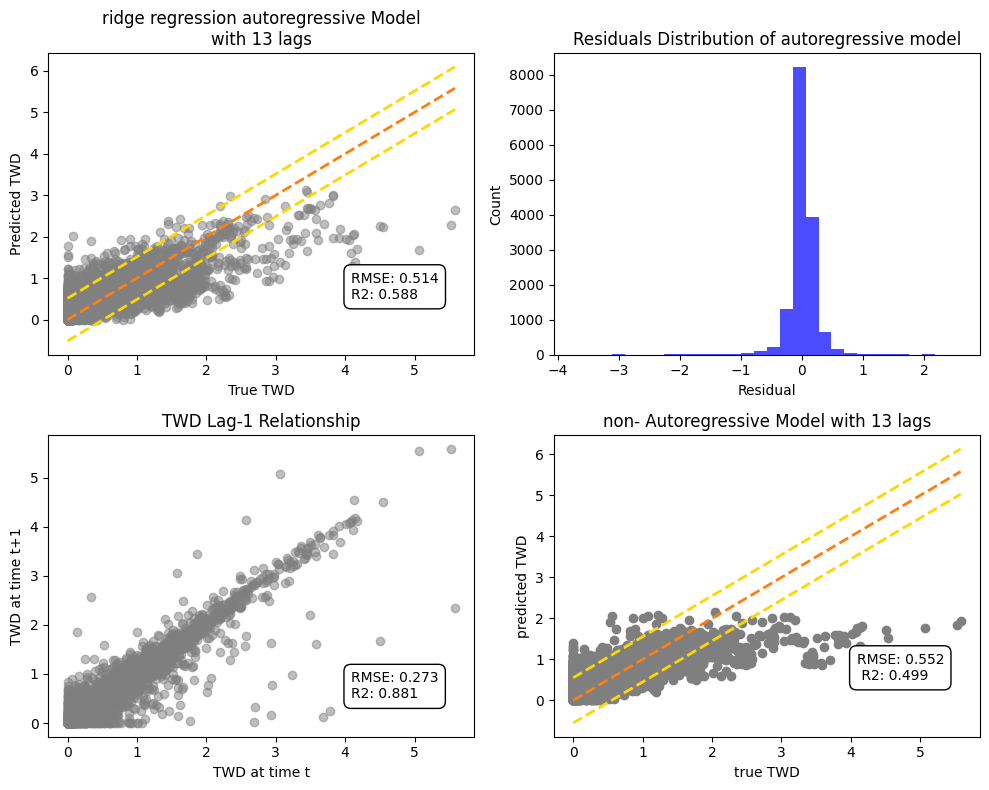

In [156]:
# Create figure with 3 subplots arranged in 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=val_y_at, y=y_pred_val_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_val_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"ridge regression autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5, y_pred_val_at.min()+0.5, 
         f"RMSE: {rmse_val_at:.3f}\nR2: {r2_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at.reshape(-1) - rgr_at.predict(train_X_at)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
rmse_lag1 = root_mean_squared_error(val_df["twd"][:-1], val_df['twd'][1:])
r2_score_lag1 = r2_score(val_df["twd"][:-1], val_df['twd'][1:])
ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# add non-auto regressive model results
x_scatter = val_y
y_scatter = y_pred_val
rmse_scatter = rmse_val
ax4.scatter(x =x_scatter, y =y_scatter, color = "tab:grey")
ax4.set_xlabel("true TWD")
ax4.set_ylabel("predicted TWD")
x_range = [x_scatter.min(), x_scatter.max()]
# how to plot y= x? 
ax4.plot(x_range,x_range, 'k--', 
lw=2, color = "tab:orange")
# can i plot two lines showing the rmse range?
ax4.plot(x_range, [i+rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
ax4.plot(x_range, [i-rmse_scatter for i in x_range], 'k--', 
lw=2, color = "gold")
ax4.set_title(f"non- Autoregressive Model with {lag_n} lags")
ax4.text(x_scatter.max()-1.5, y_scatter.min()+0.5, f"RMSE: {rmse_scatter:.3f}\n R2: {r2:.3f}", 
         fontsize=10, color="black",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

we can see that model isn't great at predicting near 0 values


let's use ridge regression as a benchmark (baseline), 
- but it is also important to understand which feature are important
- what are the outliers in the prediction
- take a look at residual?
- also wondering if we use TWD from the previous day, how would that change the prdiction? 

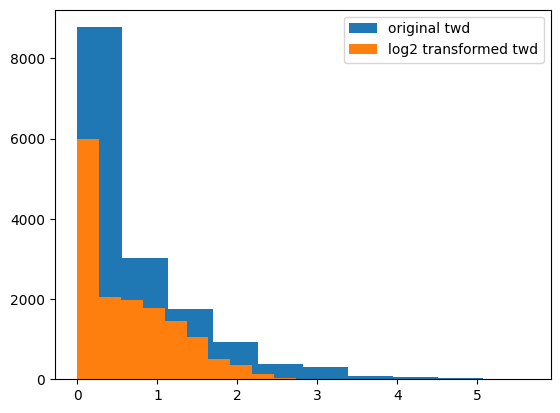

In [103]:
plt.hist(train_df['twd'])
plt.hist(train_df_log2_at['twd'])
plt.legend(['original twd', 'log2 transformed twd'])

Ridge regression performs slightly better than twd from the day before

let's take a look at feature importance

/tmp/ipykernel_6643/585808707.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 6)


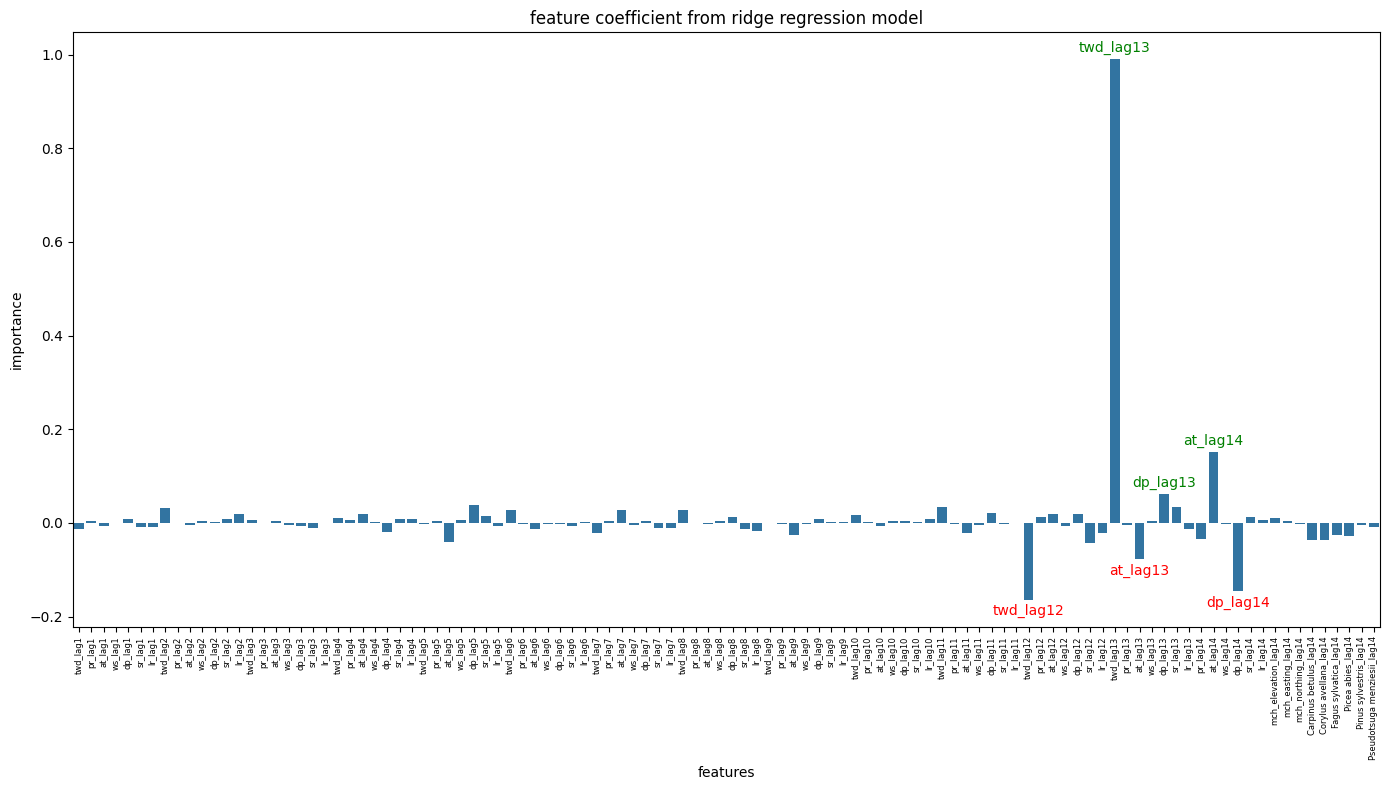

/tmp/ipykernel_6643/585808707.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 10)


Text(0.5, 1.0, 'feature coefficient (abs(feature_coef) > 0.02)# from ridge regression model')

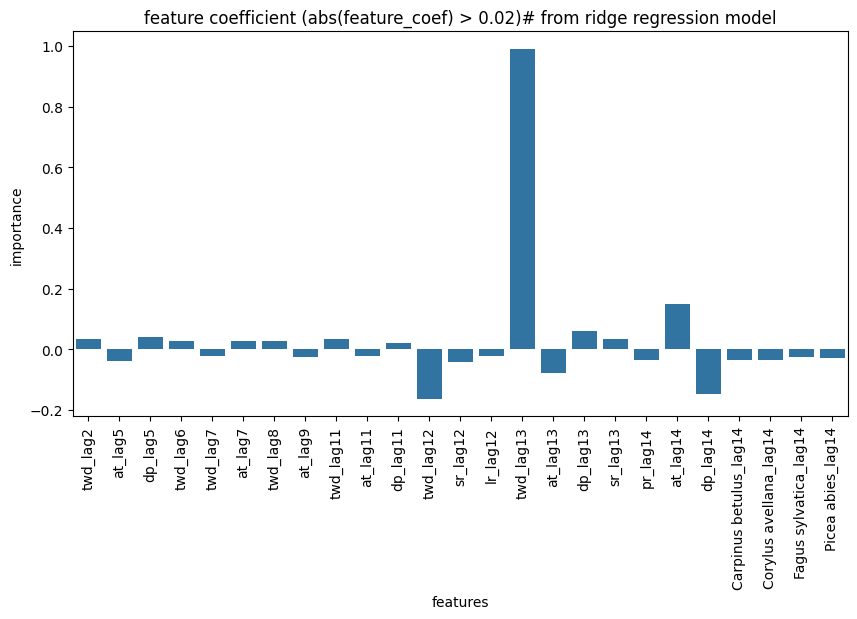

In [104]:
features_ts_cols = ['twd', 'pr', 'at', 'ws', 'dp', 'sr', 'lr']
features_ts_cols_wo_twd = ['pr', 'at', 'ws', 'dp', 'sr', 'lr']
features_static_cols = ['mch_elevation', 'mch_easting', 'mch_northing', 'Carpinus betulus',
       'Corylus avellana', 'Fagus sylvatica', 'Picea abies',
       'Pinus sylvestris', 'Pseudotsuga menziesii']

plt.figure(figsize=(14,8))
lag_labels_at = []
n_lag = 13
for i in range(1, n_lag +2):  # 24 lags
    if i == n_lag+1:
        lag_labels_at.extend([f"{col}_lag{i}" for col in features_ts_cols_wo_twd + features_static_cols])
    else:
        lag_labels_at.extend([f"{col}_lag{i}" for col in features_ts_cols])

# lag_labels = [i if "twd" in i else "" for i in lag_labels]
df_reg_imp = pd.DataFrame({
    "features": lag_labels_at,
    "importance": rgr_at.coef_}
)
# df_plot = df_reg_imp.loc[df_reg_imp.importance.abs()>0.05]
df_plot = df_reg_imp
ax = sns.barplot(df_plot, x = "features", y = "importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 6)
ax.set_title("feature coefficient from ridge regression model")
threshold = 0.05
for i, (feature, imp) in enumerate(zip(df_reg_imp['features'], df_reg_imp['importance'])):
    if abs(imp) > threshold:
        color = 'red' if imp < 0 else 'green'
        ax.text(i, imp + (0.01 if imp > 0 else -0.01), 
                feature,
                rotation=0,
                ha='center',
                va='bottom' if imp > 0 else 'top',
                fontsize=10,
                color=color)

plt.tight_layout()
plt.show()

# plt.bar(lag_labels, rgr_at.coef_)
# plt.xticks(lag_labels, rotation=90, fontsize = 7)

plt.figure(figsize=(10,5))
df_plot = df_reg_imp.loc[df_reg_imp.importance.abs()>0.02]
ax = sns.barplot(df_plot, x = "features", y = "importance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize= 10)
ax.set_title("feature coefficient (abs(feature_coef) > 0.02)# from ridge regression model")

dew point: air becomes sauratd with water vapor, direct measure off air moisture

In [28]:
reg_impt_feature_index_at = df_reg_imp.loc[df_reg_imp.importance > 0.01, ].index

reg_impt_feature_index_at
# we can use this for non-linear model

Index([ 7, 12, 13, 14, 23, 27, 28, 32, 33, 35, 44, 46, 49, 53, 56, 69, 70, 74,
       78, 79, 81, 84, 88, 89, 92, 97],
      dtype='int64')

## non-linear models
- simple models: two fcc layers?
- Gaussian?

In [29]:
from keras.models import Sequential, load_model
import tensorflow as tf
import tf_keras

In [105]:
train_X.shape[1]
lag24_num_features = train_X.shape[1]
lag24_num_features/4

23.25

### simple neural nets

In [31]:
# make tensor batch 

batch_size = 64
lag_n = 13
# train_tf= spliting_window_and_create_features(train_df, feature_window_size = lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
# train_tf_at= spliting_window_and_create_features(train_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=True,  batch_size = batch_size)

# val_tf = spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
# val_tf_at= spliting_window_and_create_features(val_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor=True, batch_size = batch_size)

# test_tf = spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=False, tensor=True,  batch_size = batch_size)
# test_tf_at= spliting_window_and_create_features(test_df, feature_window_size=lag_n, label_window_size=1, shift=1, autoregressive=True, tensor= True, batch_size = batch_size)

# train_dataset_tf = 

### non-autoregressive

In [106]:
lag_num_features = train_X.shape[1]
raw_features = tf_keras.layers.Input(shape = (lag_num_features, ))

# pre-processing
preprocessor = tf_keras.layers.Dense(40, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)


m1_z1 = tf_keras.layers.Dense(10, activation=tf.nn.relu)(preprocess_features)

m1_pred = tf_keras.layers.Dense(1, activation=tf.math.softplus)(m1_z1)


vanilla_net = tf_keras.Model(inputs=raw_features, outputs=m1_pred)#
vanilla_net_nonat =  tf_keras.Model(inputs=raw_features, outputs=m1_pred)#


vanilla_net_nonat.compile(

    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.MeanSquaredError(),  # or simply "mse"
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ]


)

# (Optional) callbacks for better training
early_stop = tf_keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=10, restore_best_weights=True
)



In [33]:
# Fit

history = vanilla_net_nonat.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=[early_stop]
)


Epoch 1/40
232/232 [==============================] - 1s 1ms/step - loss: 0.6671 - rmse: 0.8167 - mae: 0.5823 - val_loss: 0.4371 - val_rmse: 0.6611 - val_mae: 0.4375
Epoch 2/40
232/232 [==============================] - 0s 1ms/step - loss: 0.5379 - rmse: 0.7334 - mae: 0.5128 - val_loss: 0.3763 - val_rmse: 0.6134 - val_mae: 0.4069
Epoch 3/40
232/232 [==============================] - 0s 1ms/step - loss: 0.4929 - rmse: 0.7021 - mae: 0.4902 - val_loss: 0.3510 - val_rmse: 0.5924 - val_mae: 0.3943
Epoch 4/40
232/232 [==============================] - 0s 1ms/step - loss: 0.4644 - rmse: 0.6815 - mae: 0.4747 - val_loss: 0.3387 - val_rmse: 0.5820 - val_mae: 0.3852
Epoch 5/40
232/232 [==============================] - 0s 1ms/step - loss: 0.4454 - rmse: 0.6674 - mae: 0.4638 - val_loss: 0.3272 - val_rmse: 0.5720 - val_mae: 0.3783
Epoch 6/40
232/232 [==============================] - 0s 1ms/step - loss: 0.4268 - rmse: 0.6533 - mae: 0.4546 - val_loss: 0.3202 - val_rmse: 0.5659 - val_mae: 0.3741
Epoc

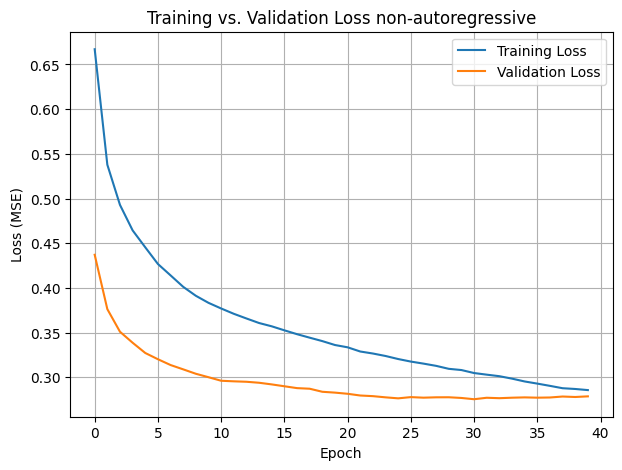

86/86 [==============================] - 0s 683us/step
rmse: 0.524880, r2: 0.546613 


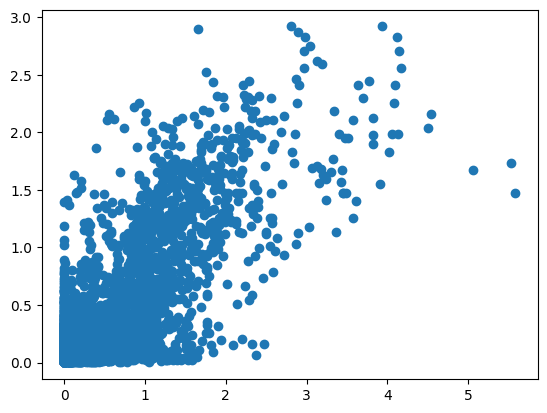

In [34]:

# history = vanilla_net.fit(...)

# Extract loss values
train_loss_nonat= history.history["loss"]
val_loss_nonat = history.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_nonat, label="Training Loss")
plt.plot(val_loss_nonat, label="Validation Loss")
plt.title("Training vs. Validation Loss non-autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


y_pred_val_net = vanilla_net_nonat.predict(val_X)# show first few predictions

rmse_net = root_mean_squared_error(y_pred_val_net, val_y)
r2_net = r2_score(val_y, y_pred_val_net)
print(f'rmse: {rmse_net:3f}, r2: {r2_net:3f} ')
plt.scatter(val_y, y_pred_val_net)

### autoregressive

In [35]:
lag24_num_features = train_X_at.shape[1]
raw_features = tf_keras.layers.Input(shape = (lag24_num_features, ))

# pre-processing
preprocessor = tf_keras.layers.Dense(40, activation=tf.nn.relu)
preprocess_features = preprocessor(raw_features)


m1_z1 = tf_keras.layers.Dense(10, activation=tf.nn.relu)(preprocess_features)

m1_pred = tf_keras.layers.Dense(1, activation=tf.math.softplus)(m1_z1) # put a exp or relu here?


vanilla_net_at = tf_keras.Model(inputs=raw_features, outputs=m1_pred)#


In [36]:

# Compile: add the missing comma; use RMSE/MAE metrics
vanilla_net_at.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.MeanSquaredError(),  # or simply "mse"
    metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)




In [38]:
# Fit

history_at = vanilla_net_at.fit(
    train_dataset_at,
    epochs=50,
    validation_data=val_dataset_at,
    callbacks=[early_stop]
)

Epoch 1/50


232/232 [==============================] - 1s 1ms/step - loss: 0.3005 - rmse: 0.5482 - mae: 0.3807 - val_loss: 0.1435 - val_rmse: 0.3788 - val_mae: 0.2588
Epoch 2/50
232/232 [==============================] - 0s 1ms/step - loss: 0.1571 - rmse: 0.3964 - mae: 0.2681 - val_loss: 0.1056 - val_rmse: 0.3250 - val_mae: 0.2215
Epoch 3/50
232/232 [==============================] - 0s 1ms/step - loss: 0.1157 - rmse: 0.3401 - mae: 0.2277 - val_loss: 0.0908 - val_rmse: 0.3014 - val_mae: 0.2030
Epoch 4/50
232/232 [==============================] - 0s 1ms/step - loss: 0.0947 - rmse: 0.3077 - mae: 0.2047 - val_loss: 0.0827 - val_rmse: 0.2875 - val_mae: 0.1916
Epoch 5/50
232/232 [==============================] - 0s 1ms/step - loss: 0.0822 - rmse: 0.2867 - mae: 0.1896 - val_loss: 0.0790 - val_rmse: 0.2811 - val_mae: 0.1862
Epoch 6/50
232/232 [==============================] - 0s 1ms/step - loss: 0.0757 - rmse: 0.2751 - mae: 0.1822 - val_loss: 0.0759 - val_rmse: 0.2755 - val_mae: 0.1812
Epoch 7/50
232/

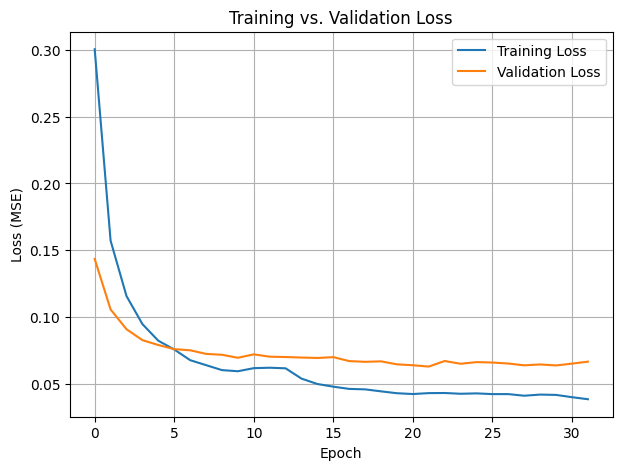

In [ ]:
# history = vanilla_net.fit(...)

# Extract loss values
train_loss_at = history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [147]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_rgr_at, y_val_rgr_at = compute_recursive_predictions_fast(rgr_at, val_df_log2_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64, tensor = False)

y_pred_val_rgr_at_ro, y_val_rgr_at_ro, y_pred_val_rgr_at_all_ro, y_val_rgr_at_all_ro = compute_recursive_predictions_fast_rollout(rgr_at, val_df_log2_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64, tensor = False)

y_pred_val_rgr_at = clip_and_inverse_log2_transform(y_pred_val_rgr_at)
y_val_rgr_at = np.power(2, y_val_rgr_at)-1
r2_score(y_val_rgr_at, y_pred_val_rgr_at)
root_mean_squared_error(y_val_rgr_at, y_pred_val_rgr_at)

print(f"r2: {r2_score(y_val_rgr_at, y_pred_val_rgr_at)}\n rmse: {root_mean_squared_error(y_val_rgr_at, y_pred_val_rgr_at)}")

r2: 0.5880387366412627
 rmse: 0.5136263692117011


In [149]:
y_pred_val_net_at, y_val_net_at = compute_recursive_predictions_fast(vanilla_net_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)

y_pred_val_net_at_ro, y_val_net_at_ro, y_pred_val_net_at_all_ro, y_val_net_at_all_ro = compute_recursive_predictions_fast_rollout(vanilla_net_at, val_df_at, feature_window_size=lag_n,
label_window_size=1, shift=1, config=config, batch_size=64)
r2_net_at = r2_score(y_val_net_at, y_pred_val_net_at)
rmse_net_at = root_mean_squared_error(y_val_net_at, y_pred_val_net_at)
print(f'rmse: {rmse_net_at:3f}, r2: {r2_net_at:3f} ')

3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 1ms/step
rmse: 0.792304, r2: 0.019731 


In [160]:
y_val_net_at_all_ro[:, 0].reshape(-1)

array([0.08742675, 0.08665722, 0.08382791, ..., 0.        , 0.        ,
       0.        ], shape=(3000,))

In [161]:
r2_score(y_val_net_at_all_ro[:, 0].reshape(-1), y_pred_val_net_at_all_ro[:, 0].reshape(-1))

0.8916162466008862

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


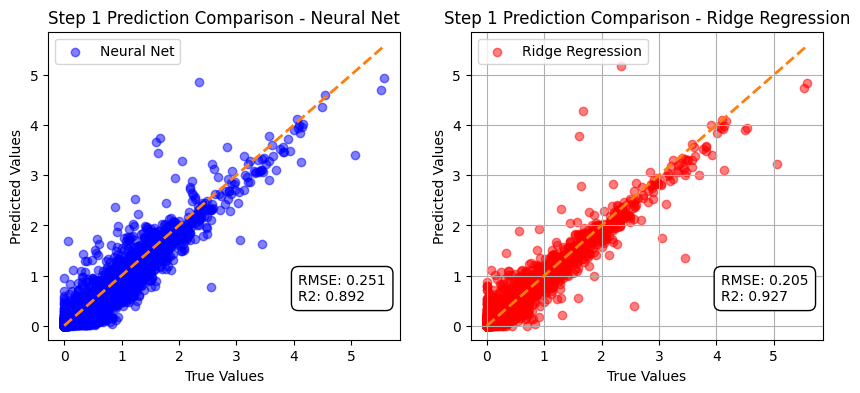

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


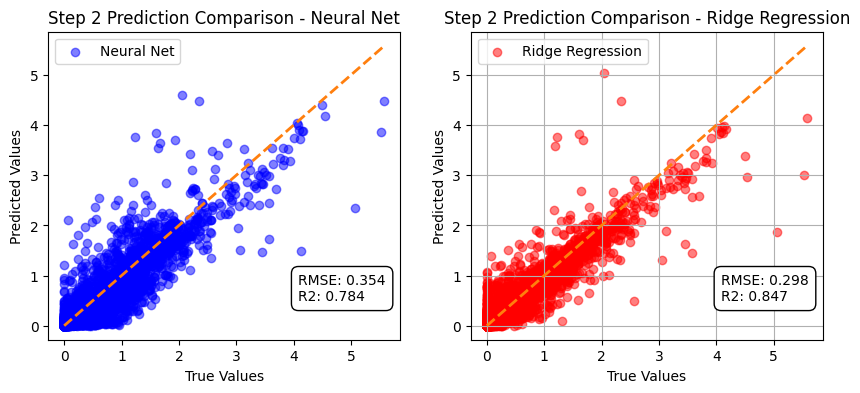

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


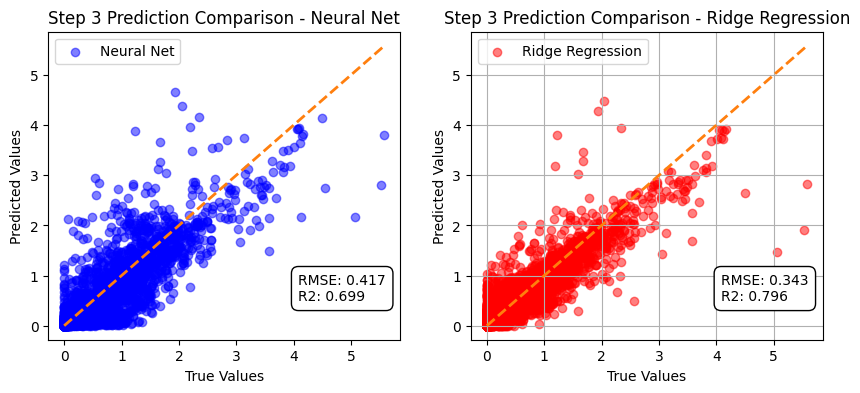

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


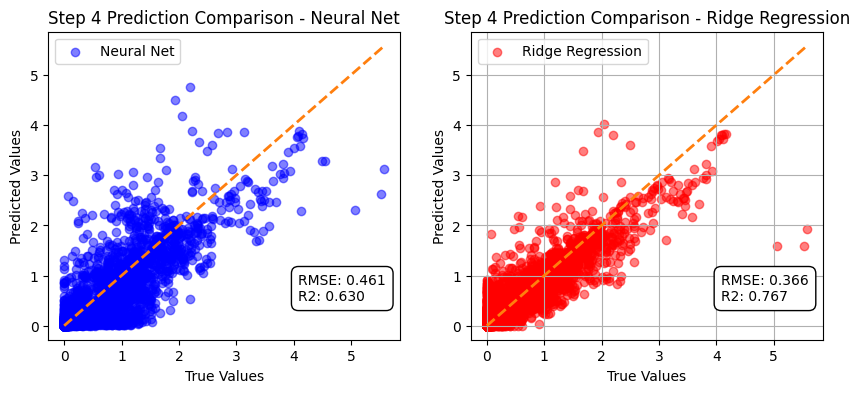

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


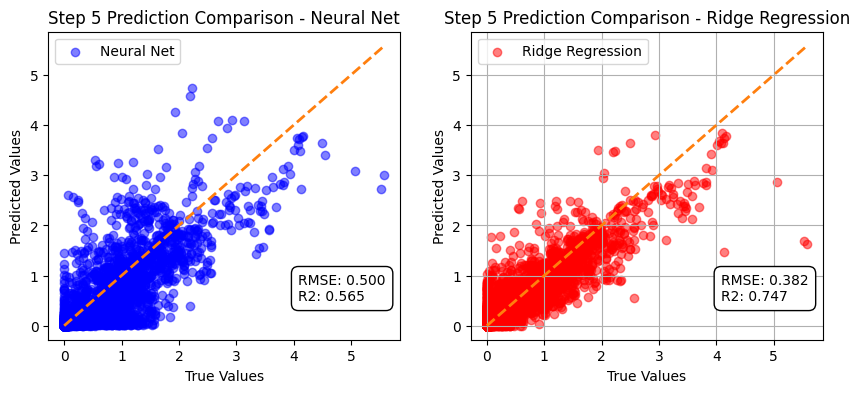

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


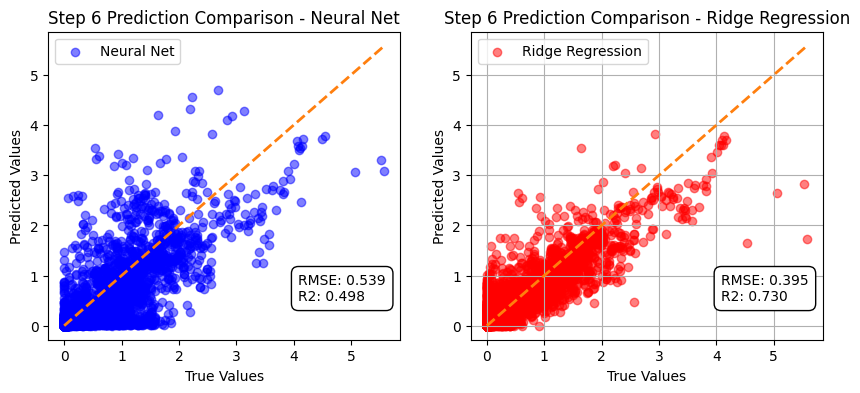

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


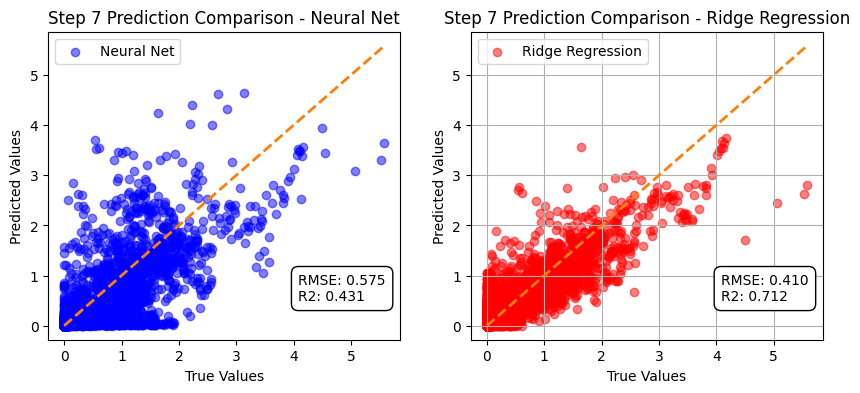

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


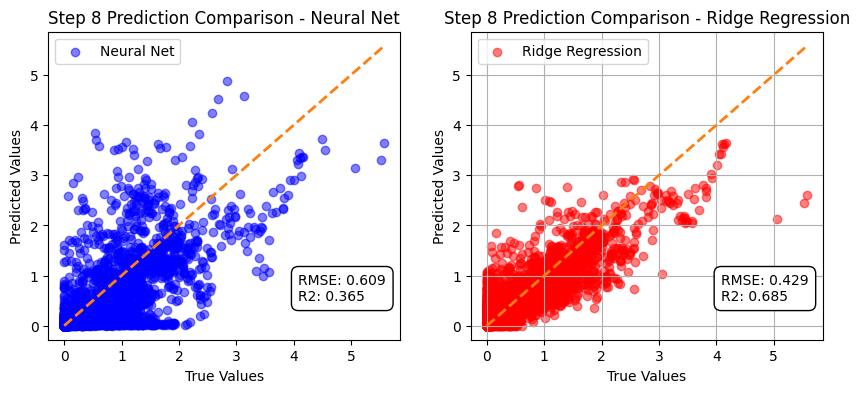

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


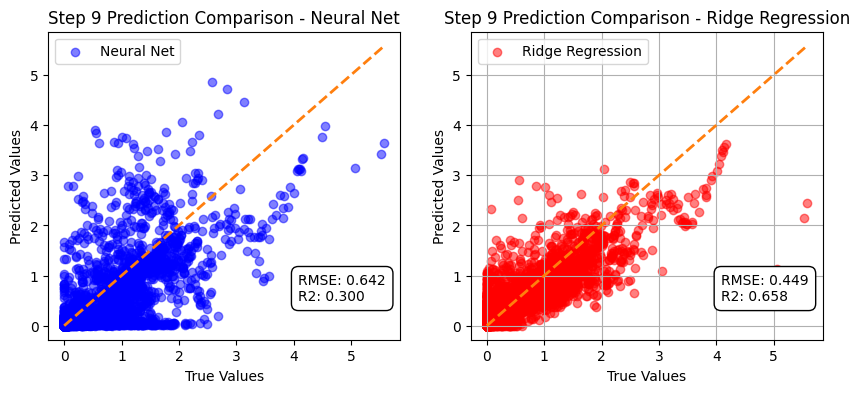

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


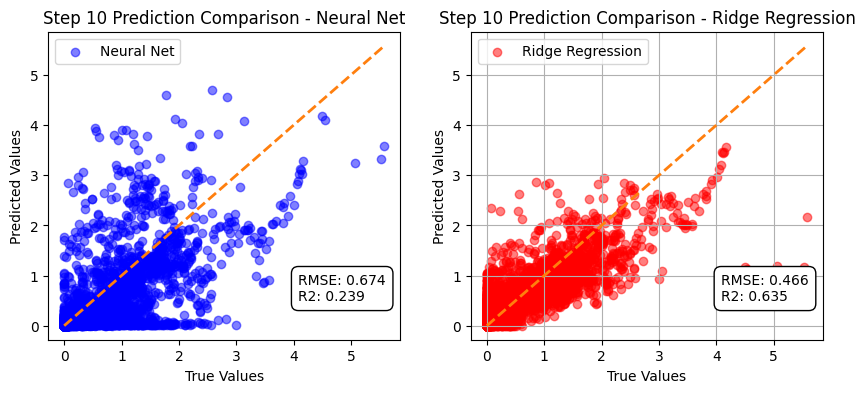

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


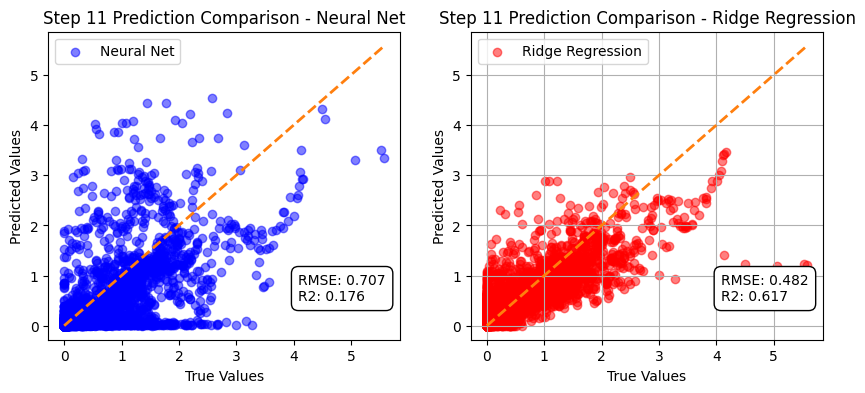

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


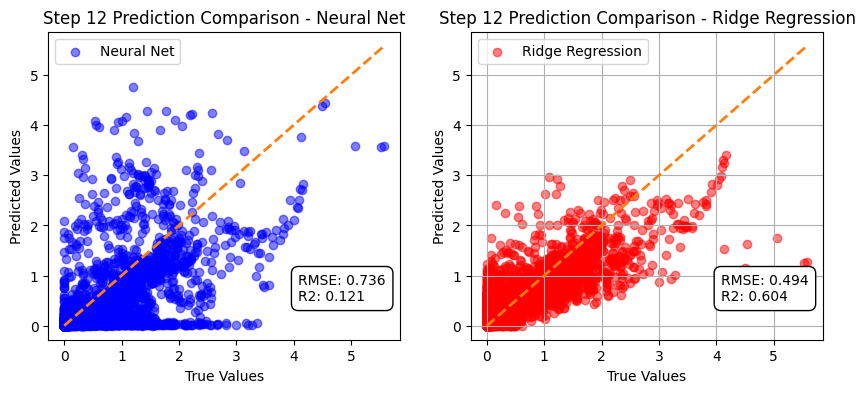

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


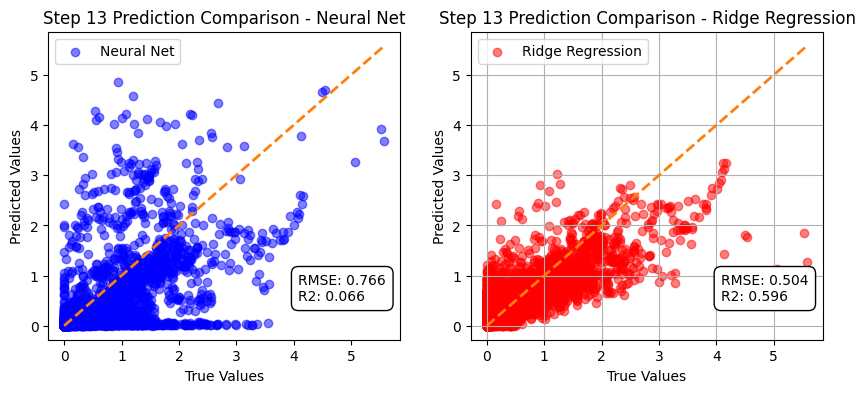

/tmp/ipykernel_6643/159815507.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()),
/tmp/ipykernel_6643/159815507.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()),


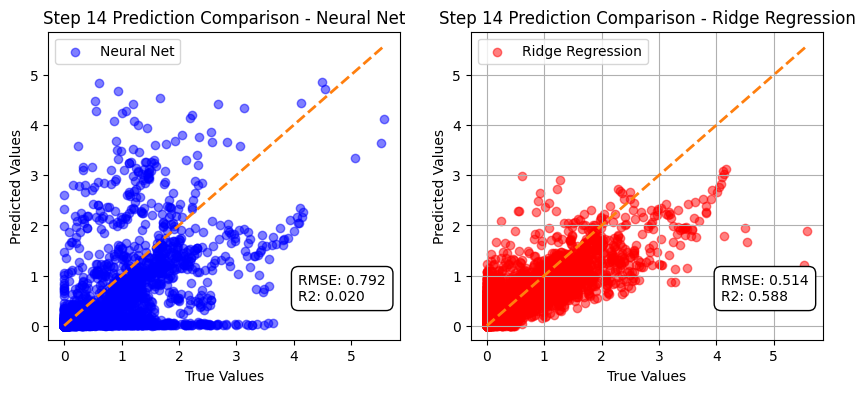

In [163]:
# y_pred_val_net_at_all_ro, y_val_net_at_all_ro
# y_pred_val_rgr_at_all_ro, y_val_rgr_at_all_ro

# diagnosis step by step comparison between neural net and ridge regression

for step in range(0, lag_n + 1):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    y_ridge_step_true = np.power(2, y_val_rgr_at_all_ro[:, step].reshape(-1))-1
    y_ridge_step_pred = clip_and_inverse_log2_transform(y_pred_val_rgr_at_all_ro[:, step].reshape(-1))

    ax1.scatter(y_val_net_at_all_ro[:, step].reshape(-1), y_pred_val_net_at_all_ro[:, step].reshape(-1), color='blue', alpha=0.5, label='Neural Net')
    ax2.scatter(y_ridge_step_true, y_ridge_step_pred, color='red', alpha=0.5, label='Ridge Regression')
    
    ax1.set_title(f'Step {step+1} Prediction Comparison - Neural Net')
    ax2.set_title(f'Step {step+1} Prediction Comparison - Ridge Regression')
    
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Predicted Values')
    
    ax1.plot([min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()), 
              max(y_val_net_at_all_ro[:, step].max(), y_pred_val_net_at_all_ro[:, step].max())],
             [min(y_val_net_at_all_ro[:, step].min(), y_pred_val_net_at_all_ro[:, step].min()), 
              max(y_val_net_at_all_ro[:, step].max(), y_pred_val_net_at_all_ro[:, step].max())],
             'k--', lw=2, color='tab:orange')   
    # plot text of rmse and r2 for neural net 
    rmse_net_step = root_mean_squared_error(y_val_net_at_all_ro[:, step].reshape(-1), y_pred_val_net_at_all_ro[:, step].reshape(-1))
    r2_net_step = r2_score(y_val_net_at_all_ro[:, step].reshape(-1), y_pred_val_net_at_all_ro[:, step].reshape(-1))
    ax1.text(y_val_net_at_all_ro[:, step].max()-1.5, y_pred_val_net_at_all_ro[:, step].min()+0.5, 
         f"RMSE: {rmse_net_step:.3f}\nR2: {r2_net_step:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    ax2.plot([min(y_ridge_step_true.min(), y_ridge_step_true.min()), 
              max(y_ridge_step_true.max(), y_ridge_step_true.max())],
             [min(y_ridge_step_true.min(), y_ridge_step_true.min()), 
              max(y_ridge_step_true.max(), y_ridge_step_true.max())],
             'k--', lw=2, color='tab:orange')   
    rmse_rgr_step = root_mean_squared_error(y_ridge_step_true, y_ridge_step_pred)
    r2_rgr_step = r2_score(y_ridge_step_true, y_ridge_step_pred)
    ax2.text(y_ridge_step_true.max()-1.5, y_ridge_step_pred.min()+0.5, 
         f"RMSE: {rmse_rgr_step:.3f}\nR2: {r2_rgr_step:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    ax1.legend()
    ax2.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# investigate 1-day ahead prediction performance for autoregressive neural net
# y_pred_1d = vanilla_net_at.predict(val_X_at).reshape(-1)
# y_pred_1d_bt =[]
# y_true_1d_bt = []

# for x,y in val_dataset_at:
#     y_pred_1d_bt.append(vanilla_net_at.predict(x).reshape(-1))
#     y_true_1d_bt.append(y)

# y_pred_1d_bt = np.concatenate(y_pred_1d_bt)
# y_true_1d_bt = np.concatenate(y_true_1d_bt)

# r2_1d = r2_score(val_y_at, y_pred_1d)
# r2_1d_bt = r2_score(y_true_1d_bt, y_pred_1d_bt)

# rmse_1d = root_mean_squared_error(val_y_at, y_pred_1d) 
# rmse_1d_bt = root_mean_squared_error(y_true_1d_bt, y_pred_1d_bt)

# print(f'rmse: {rmse_1d:3f}, r2: {r2_1d:3f} ')

# print(f'rmse_bt: {rmse_1d_bt:3f}, r2: {r2_1d_bt:3f} ')
# plt.scatter(y_pred_1d, val_y_at)
# plt.scatter( y_pred_1d_bt, y_true_1d_bt)

230/463 [=============>................] - ETA: 0s

/tmp/ipykernel_6643/4131726233.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_6643/4131726233.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i+rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_6643/4131726233.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(x_range, [i-rmse_net_at for i in x_range], 'k--', lw=2, color="gold")


463/463 [==============================] - 0s 657us/step


/tmp/ipykernel_6643/4131726233.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
/tmp/ipykernel_6643/4131726233.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i+rmse_net for i in x_range], 'k--', lw=2, color="gold")
/tmp/ipykernel_6643/4131726233.py:45: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax4.plot(x_range, [i-rmse_net for i in x_range], 'k--', lw=2, color="gold")


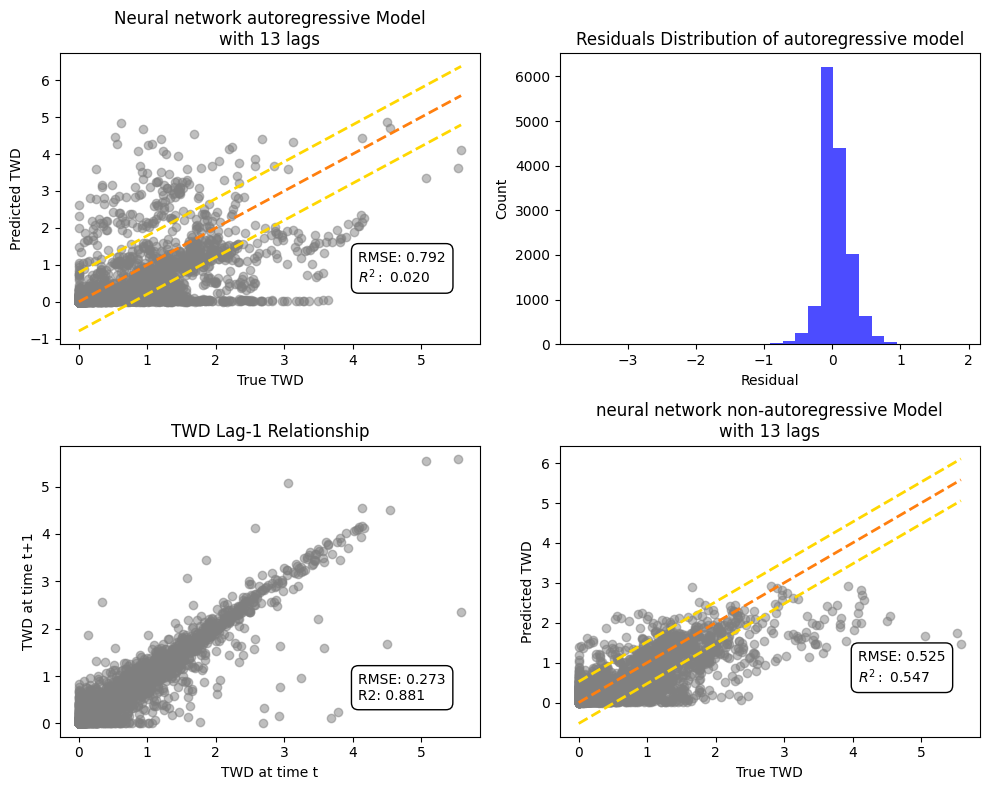

In [164]:
# Create figure with 3 subplots arranged in 1 row and 3 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# First subplot - Autoregressive Model Predictions
ax1.scatter(x=y_val_net_at, y=y_pred_val_net_at, color="grey", alpha=0.5)
ax1.set_xlabel("True TWD")
ax1.set_ylabel("Predicted TWD")
x_range = [val_y_at.min(), val_y_at.max()]
ax1.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax1.plot(x_range, [i+rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
ax1.plot(x_range, [i-rmse_net_at for i in x_range], 'k--', lw=2, color="gold")
ax1.set_title(f"Neural network autoregressive Model\nwith {lag_n} lags")
ax1.text(val_y_at.max()-1.5,y_pred_val_net_at.min()+0.5, 
         f"RMSE: {rmse_net_at:.3f}\n$R^2:$ {r2_net_at:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Second subplot - Residuals histogram
y_res = train_y_at.reshape(-1) - vanilla_net_at.predict(train_X_at).reshape(-1)
ax2.hist(y_res, bins=30, color='blue', alpha=0.7)
ax2.set_xlabel("Residual")
ax2.set_ylabel("Count")
ax2.set_title("Residuals Distribution of autoregressive model")



# Third subplot - Lag-1 TWD relationship
ax3.scatter(val_df["twd"][:-1], val_df['twd'][1:], color='tab:grey', alpha=0.5)
ax3.set_xlabel("TWD at time t")
ax3.set_ylabel("TWD at time t+1")
ax3.set_title("TWD Lag-1 Relationship")
ax3.text(val_df["twd"][:-1].max()-1.5, val_df['twd'][1:].min()+0.5, 
         f"RMSE: {rmse_lag1:.3f}\nR2: {r2_score_lag1:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))



# fourth subplot - non-Autoregressive Model Predictions
ax4.scatter(x=val_y, y=y_pred_val_net.reshape(-1), color="grey", alpha=0.5)
ax4.set_xlabel("True TWD")
ax4.set_ylabel("Predicted TWD")
x_range = [val_y.min(), val_y.max()]
ax4.plot(x_range, x_range, 'k--', lw=2, color="tab:orange")
ax4.plot(x_range, [i+rmse_net for i in x_range], 'k--', lw=2, color="gold")
ax4.plot(x_range, [i-rmse_net for i in x_range], 'k--', lw=2, color="gold")
ax4.set_title(f"neural network non-autoregressive Model\nwith {lag_n} lags")
ax4.text(val_y.max()-1.5,y_pred_val_net.min()+0.5, 
         f"RMSE: {rmse_net:.3f}\n$R^2:$ {r2_net:.3f}", 
         fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))






# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()